In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0ef6fc3b85405f18aff2f1d5580ac58c0dce1fa3031857532908ce3bd01c7877
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget
import zipfile

In [ ]:
url = 'http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip'
wget.download(url)

'caption_datasets.zip'

In [ ]:
archive = 'caption_datasets.zip'
with zipfile.ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This archiv of dataset you can download from https://www.kaggle.com/datasets/adityajn105/flickr8k


In [ ]:
archive = '/content/drive/MyDrive/flickr.zip'
with zipfile.ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

In [ ]:
# utils.py

import os
import numpy as np
import h5py
import json
import torch
from imageio import imread
from PIL import Image
#from scipy.misc import imread, imresize
import cv2
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample


def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,
                       max_len=100):

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}


    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()

    for img in data['images']:
        captions = []
        for c in img['sentences']:
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])

        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])

        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)


    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # mapping words
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0


    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

    # create json
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    # create hdf5 files
    seed(123)
    count = -1
    dataset_lens = [4877, 827, 829] #coco - 87840, 3872, 3865
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:
        count += 1
        print("impaths ", len(impaths))

        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:

            h.attrs['captions_per_image'] = captions_per_image

            # create dataset in hdf5 files
            images = h.create_dataset('images', (dataset_lens[count], 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []
            k = 0
            for i, path in enumerate(tqdm(impaths)):


                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)


                assert len(captions) == captions_per_image

                # read images
                img = imread(impaths[i])
                if len(img.shape) == 2:
                    img = img[:, :, np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                img = cv2.resize(img, (256, 256))#np.array(Image.fromarray(img).resize((256, 256)))#cv2.resize(img, (256, 256))#imresize(img, (256, 256))
                img = img.transpose(2, 0, 1)
                #assert img.shape == (3, 256, 256)
                #assert np.max(img) <= 255
                if (img.shape != (3, 256, 256) or np.max(img) != 255):
                  continue

                images[k] = img
                k += 1

                for j, c in enumerate(captions):
                    # encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            print("count", count)
            print("images.shape[0] * captions_per_image", images.shape[0] * captions_per_image)
            print("len(enc_captions)", len(enc_captions))
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

            # save captions to json
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)


def init_embedding(embeddings):

    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):

    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim


def clip_gradient(optimizer, grad_clip):

    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):

    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)

    if is_best:
        torch.save(state, 'BEST_' + filename)
        


class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):

    batch_size = targets.size(0)
    #print("batch_size = ", batch_size)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
create_input_files(dataset='flickr8k',
                    karpathy_json_path='./dataset_flickr8k.json',
                    image_folder='/content/Images',
                    captions_per_image=5,
                    min_word_freq=5,
                    output_folder='./',
                    max_len=50)

impaths  6000

Reading TRAIN images and captions, storing to file...



100%|██████████| 6000/6000 [00:45<00:00, 131.45it/s]


count 0
images.shape[0] * captions_per_image 24385
len(enc_captions) 24385
impaths  1000

Reading VAL images and captions, storing to file...



100%|██████████| 1000/1000 [00:06<00:00, 161.12it/s]


count 1
images.shape[0] * captions_per_image 4135
len(enc_captions) 4135
impaths  1000

Reading TEST images and captions, storing to file...



100%|██████████| 1000/1000 [00:06<00:00, 162.69it/s]


count 2
images.shape[0] * captions_per_image 4145
len(enc_captions) 4145


In [ ]:
import os
import zipfile
 
fantasy_zip = zipfile.ZipFile('hdf5_files.zip', 'w')
 
fantasy_zip.write('/content/TEST_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/TEST_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/TEST_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/TEST_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/TEST_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', '/content/TEST_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/TRAIN_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', '/content/TRAIN_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/VAL_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/VAL_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/VAL_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/VAL_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/VAL_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', '/content/VAL_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5', compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.write('/content/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json', '/content/TEST_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json', compress_type = zipfile.ZIP_DEFLATED)

fantasy_zip.close()

/usr/lib/python3.7/zipfile.py:1506: UserWarning: Duplicate name: 'content/TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.7/zipfile.py:1506: UserWarning: Duplicate name: 'content/TEST_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


In [ ]:
#datasets

import torch
from torch.utils.data import Dataset
import h5py
import json
import os


class CaptionDataset(Dataset):

    def __init__(self, data_folder, data_name, split, transform=None):

        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # stored images from hdf5
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        self.cpi = self.h.attrs['captions_per_image']

        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        self.transform = transform
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):

        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

In [ ]:
# lstm or gru model with 1 layer
# Different ResNet was tryied for encoder. The best variant is ResNet101

import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
# Remove classification layer from ResNet

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):

        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):

        for p in self.resnet.parameters():
            p.requires_grad = False

        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


class Attention(nn.Module):
#calulete attention

    def __init__(self, encoder_dim, decoder_dim, attention_dim):

        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):

        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
# lstm with attention

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5, decode_name = "LSTM"):

        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        if decode_name == "LSTM":
            self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
            self.decode_step_LSTM = nn.LSTM(embed_dim + encoder_dim, decoder_dim, 2)  # decoding LSTM
        else:
            self.decode_step = nn.GRUCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding GRUCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()
        #self.load_pretrained_embeddings(self.embedding)

    def init_weights(self):

        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):

        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):

        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):

        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        #print(encoder_out)
        #print(encoder_out.size())
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        #print(h.size(), c.size())
        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        #at each step calculate attention and after LSTMCell
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            #print((h[:batch_size_t], c[:batch_size_t]))
            #print(h[:batch_size_t].size(), c[:batch_size_t].size())
            #print(torch.reshape(h[:batch_size_t], (1, 32, -1)).size())
            #print(embeddings[:batch_size_t, t, :].size(), attention_weighted_encoding.size())
            #print(torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1).size(), h.size())
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
# WARNING!!!!
# Run this cell, if you want to use two layers LSTM or GRU

class DecoderWithAttention(nn.Module):


    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5, decode_name = "LSTM"):

        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        if decode_name == "LSTM":
            self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
            self.decode_step1 = nn.LSTMCell(decoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
            #self.decode_step_LSTM = nn.LSTM(decoder_dim, decoder_dim, 2)  # decoding LSTM
        else:
            self.decode_step = nn.GRUCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding GRUCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.init_h1 = nn.Linear(encoder_dim, decoder_dim)
        self.init_c1 = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution
        #self.load_pretrained_embeddings(self.embedding)

    def init_weights(self):

        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):

        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):

        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):

        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        h1 = self.init_h1(mean_encoder_out)  # (batch_size, decoder_dim)
        c1 = self.init_c1(mean_encoder_out)
        return h, c, h1, c1

    def forward(self, encoder_out, encoded_captions, caption_lengths):

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        #print(encoder_out)
        #print(encoder_out.size())
        # Initialize LSTM state
        h, c, h1, c1 = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        #print(h.size(), c.size())
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # at each step we calculate attention for image, transfer to lstmcell
        # and at the next step  we transfer attention and first output to second layer
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            #print((h[:batch_size_t], c[:batch_size_t]))
            #print(h[:batch_size_t].size(), c[:batch_size_t].size())
            #print(torch.reshape(h[:batch_size_t], (1, 32, -1)).size())
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            print("lstm2")
            h1, c1 = self.decode_step(
                torch.cat([h, attention_weighted_encoding], dim=1),
                (h1[:batch_size_t], c1[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h1))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
!cp ./drive/MyDrive/BEST_checkpoint_flickr8k_lstm_5_cap_per_img_5_min_word_freq.pth.tar /content/

In [ ]:
#train

data_folder = ''  # files from create_input_files.py
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'

emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True

start_epoch = 0
epochs = 10  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1
encoder_lr = 1e-3  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = True  # fine-tune encoder?
checkpoint = None#'/content/drive/MyDrive/BEST_checkpoint_flickr8k_lstm_2_5_cap_per_img_5_min_word_freq.pth.tar'#None#'./drive/MyDrive/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'  # path to checkpoint, None if none


def main():

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    # Initialize / load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout,
                                       decode_name="LSTM")
        decoder.fine_tune_embeddings(True)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)


    decoder = decoder.to(device)
    encoder = encoder.to(device)


    criterion = nn.CrossEntropyLoss().to(device)


    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        targets = caps_sorted[:, 1:]


        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores.data, targets.data)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores.data, targets.data, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()
        

        # Print status
        if i % print_freq == 0:
            with open('/content/LSTM2.txt', 'a') as f:
                f.write("Epoch " + str(epoch) \
                        + " Loss " + str(losses.val)  \
                        + " Accuracy " + str(top5accs.avg) + "\n")
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):

    decoder.eval()
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # true captions
    hypotheses = list()  # predictions

    with torch.no_grad():
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            targets = caps_sorted[:, 1:]

            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores.data, targets.data)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores.data, targets.data, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()


            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            allcaps = allcaps[sort_ind] 
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))
                references.append(img_captions)

            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
        #print(references)
        #print(hypotheses)

        with open('/content/LSTM2.txt', "a") as f:
            f.write("Loss " + str(losses.avg)  \
                    + " Accuracy " + str(top5accs.avg) \
                    + " BLEU "+ str(bleu4) + "\n")

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [ ]:
main()

Epoch: [0][0/763]	Batch Time 0.685 (0.685)	Data Load Time 0.139 (0.139)	Loss 8.7912 (8.7912)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/763]	Batch Time 0.513 (0.510)	Data Load Time 0.000 (0.002)	Loss 5.8165 (6.1325)	Top-5 Accuracy 32.533 (35.124)
Epoch: [0][200/763]	Batch Time 0.521 (0.516)	Data Load Time 0.000 (0.001)	Loss 5.1993 (5.7822)	Top-5 Accuracy 49.347 (39.291)
Epoch: [0][300/763]	Batch Time 0.514 (0.522)	Data Load Time 0.000 (0.001)	Loss 4.8395 (5.5470)	Top-5 Accuracy 53.353 (42.617)
Epoch: [0][400/763]	Batch Time 0.550 (0.526)	Data Load Time 0.000 (0.001)	Loss 4.6992 (5.3756)	Top-5 Accuracy 54.703 (45.024)
Epoch: [0][500/763]	Batch Time 0.547 (0.529)	Data Load Time 0.000 (0.001)	Loss 4.7531 (5.2505)	Top-5 Accuracy 52.806 (46.701)
Epoch: [0][600/763]	Batch Time 0.547 (0.531)	Data Load Time 0.000 (0.001)	Loss 4.7621 (5.1554)	Top-5 Accuracy 52.196 (47.972)
Epoch: [0][700/763]	Batch Time 0.562 (0.534)	Data Load Time 0.000 (0.001)	Loss 4.4468 (5.0744)	Top-5 Accuracy 56.802 (49.0

In [ ]:
!cp /content/checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar /content/drive/MyDrive/ImageCaptioning/checkpoint_flickr8k_coco_5_cap_per_img_5_min_word_freq.pth.tar

In [ ]:
!cp /content/LSTM2.txt /content/drive/MyDrive/ImageCaptioning/LSTM_renet50.txt

In [ ]:
!cp /content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar /content/drive/MyDrive/ImageCaptioning/BEST_checkpoint_flickr8k_tanh_5_cap_per_img_5_min_word_freq.pth.tar

In [ ]:
!cp /content/LSTM2.txt /content/drive/MyDrive/ImageCaptioning/LSTM2_ver1.txt

In [ ]:
!cp /content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar /content/drive/MyDrive/BEST_checkpoint_flickr8k_lstm_2_5_cap_per_img_5_min_word_freq.pth.tar

In [ ]:
# evaluate

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
from tqdm import tqdm

# Parameters
data_folder = ''  # folder with data files saved by create_input_files.py
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  # base name shared by data files
checkpoint = '/content/drive/MyDrive/BEST_checkpoint_flickr8k_lstm_5_cap_per_img_5_min_word_freq.pth.tar'
word_map_file = '/content/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Load model
checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def evaluate(beam_size):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        seqs = k_prev_words  # (k, 1)

        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        complete_seqs = list()
        complete_seqs_scores = list()

        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)

            awe, _ = decoder.attention(encoder_out, h)

            gate = decoder.sigmoid(decoder.f_beta(h))
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))

            scores = decoder.fc(h)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            seqs = torch.cat([seqs[prev_word_inds.long()].long(), next_word_inds.unsqueeze(1).long()], dim=1)  # (s, step+1)
            #print(seqs)

            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            #print(complete_inds)

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly
            #print(top_k_scores[complete_inds])

            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds].long()]
            c = c[prev_word_inds[incomplete_inds].long()]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            if step > 50:
                break
            step += 1

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses)

    return bleu4


if __name__ == '__main__':
    beam_size = 5
    print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, evaluate(beam_size)))

EVALUATING AT BEAM SIZE 5: 100%|██████████| 4145/4145 [03:50<00:00, 17.95it/s]



BLEU-4 score @ beam size of 5 is 0.2200.


In [ ]:
/content/TEST_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5
/сontent/TEST_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from imageio import imread
import cv2
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):


    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = cv2.resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    seqs = k_prev_words  # (k, 1)

    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()


    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h = decoder.decode_step(torch.cat([embeddings, awe], dim=1), h)  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        seqs = torch.cat([seqs[prev_word_inds.long()].long(), next_word_inds.unsqueeze(1).long()], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()].long(), alpha[prev_word_inds.long()].unsqueeze(1).long()],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


In [ ]:
# If you want only picture and description

def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = ""
    for ind in seq:
      words += rev_word_map[ind]
      words += " "

    plt.imshow(image)
    plt.text(0, 1, '%s' % (words), color='black', backgroundcolor='white', fontsize=12)

    plt.show()

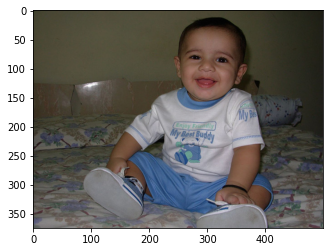

In [ ]:
from PIL import Image
#...
img = Image.open('/content/Images/934375844_dd149fed18.jpg')
plt.imshow(img)

950273886_88c324e663.jpg

3376898612_41c91de476.jpg

977856234_0d9caee7b2.jpg

3388094307_5a83be64a5.jpg

3389448506_7025e7cc12.jpg

888517718_3d5b4b7b43.jpg !!!

934375844_dd149fed18.jpg !!!

3373544964_c9f1253b7d.jpg !!

938162709_21443d352f.jpg !!!

3374384485_751f719be4.jpg !!!

2683985894_167d267dcb.jpg !!!


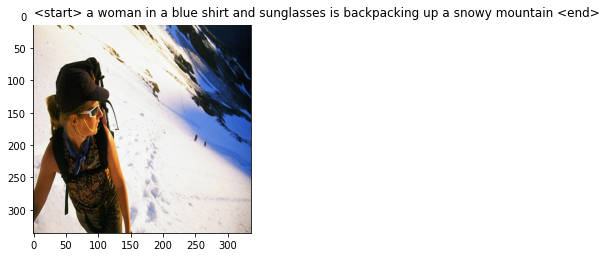

In [ ]:
model = '/content/drive/MyDrive/ImageCaptioning/BEST_checkpoint_flickr8k_gru_5_cap_per_img_5_min_word_freq.pth.tar'
img = '/content/Images/390987167_2d5905b459.jpg'
word_map = '/content/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'
beam_size = 5
#!cd /content/a-PyTorch-Tutorial-to-Image-Captioning-master && python caption.py --img='/content/a-PyTorch-Tutorial-to-Image-Captioning-master/img/babycake.png' --model='/content/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar' --word_map='/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json' --beam_size=5

# Load model
checkpoint = torch.load(model, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open(word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

visualize_att(img, seq, alphas, rev_word_map)

In [ ]:
# !wget 'https://i.playground.ru/i/pix/1418076/image.jpg'

--2022-06-01 07:18:45--  https://i.playground.ru/i/pix/1418076/image.jpg
Resolving i.playground.ru (i.playground.ru)... 212.42.38.199
Connecting to i.playground.ru (i.playground.ru)|212.42.38.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1695998 (1.6M) [image/jpeg]
Saving to: ‘image.jpg.1’

image.jpg.1         100%[===================>]   1.62M  1.07MB/s    in 1.5s    

2022-06-01 07:18:48 (1.07 MB/s) - ‘image.jpg.1’ saved [1695998/1695998]



In [2]:
def calc_metrics(file):
    accuracy = []
    loss = []
    bleu = []
    with open(file) as file:
      for line in file:
        line = line.split(" ")
        if line[0] == "Epoch":
          pass
          #loss.append(float(line[3]))
          #accuracy.append(float(line[5][:-1]))
        else:
          accuracy.append(float(line[3]))
          loss.append(float(line[1]))
          bleu.append(float(line[5][:-1]))
    return (accuracy, loss, bleu)
    
  

In [3]:
from matplotlib import pyplot as plt   

def plot_metrics(metrics, name):

    fig, axs = plt.subplots(1, 3)
    fig.suptitle(name)   
    axs[0].plot(metrics[0])
    axs[0].set(xlabel='epoch', ylabel='accuracy')
    axs[1].plot(metrics[1])
    axs[1].set(xlabel='epoch', ylabel='loss')
    axs[2].plot(metrics[2])
    axs[2].set(xlabel='epoch', ylabel='bleu')
    plt.rcParams['figure.figsize'] = [20, 6]
    plt.show()

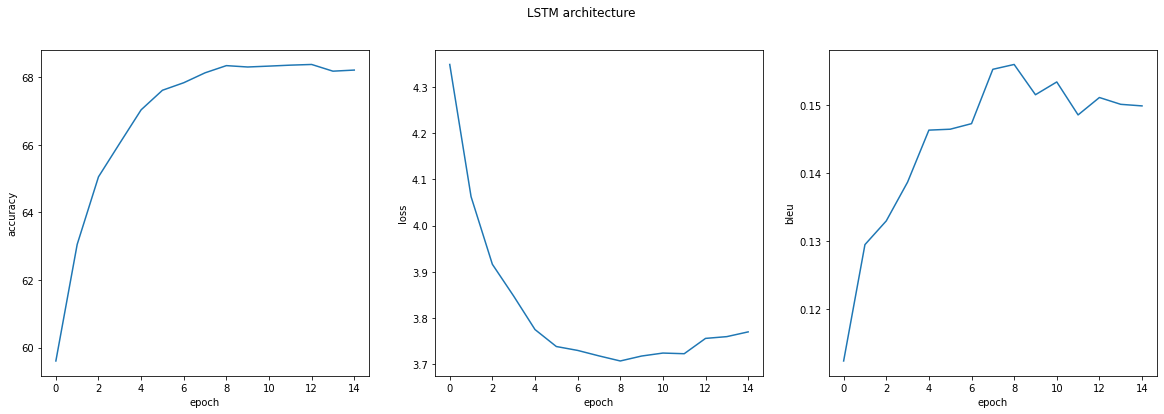

In [7]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/LSTM.txt")
plot_metrics(metrs, "LSTM architecture")

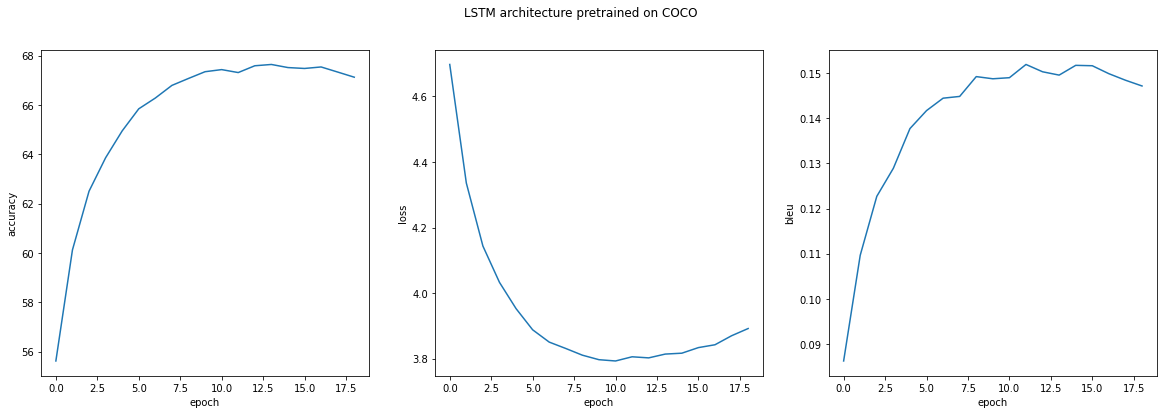

In [ ]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/LSTM_coco.txt")
plot_metrics(metrs, "LSTM architecture pretrained on COCO")

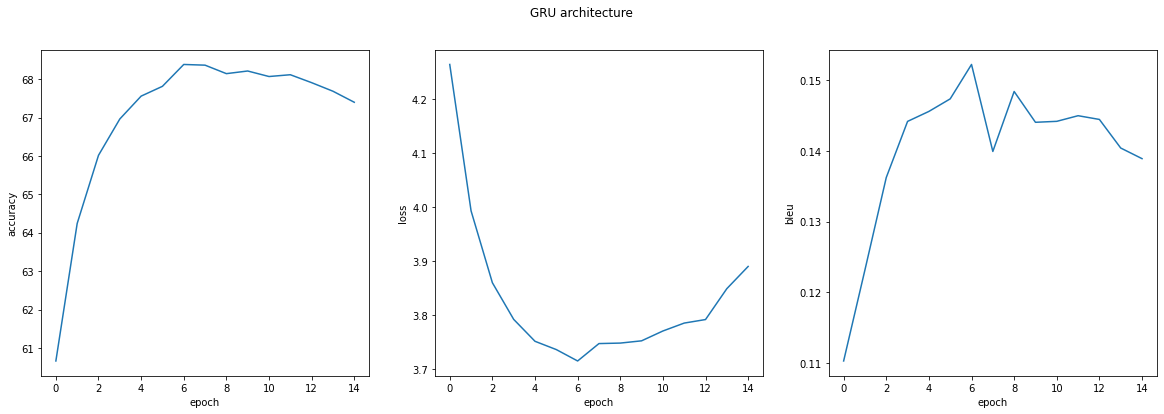

In [ ]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/GRU.txt")
plot_metrics(metrs, "GRU architecture")

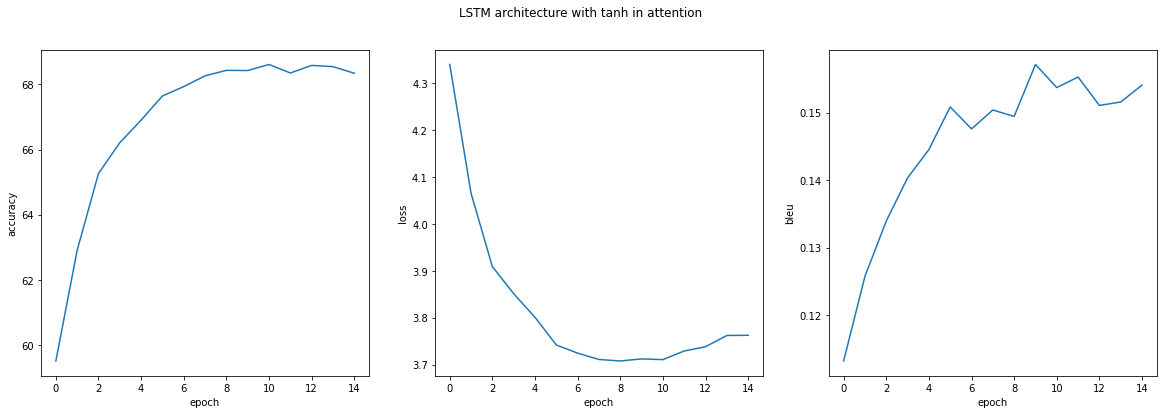

In [ ]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/LSTM_tanh.txt")
plot_metrics(metrs, "LSTM architecture with tanh in attention")

In [ ]:
bleu_lstm = []
bleu_tanh = []
with open("/content/drive/MyDrive/ImageCaptioning/LSTM.txt") as file:
  for line in file:
    line = line.split(" ")
    if line[0] != "Epoch":
      bleu_lstm.append(float(line[5][:-1]))

with open("/content/drive/MyDrive/ImageCaptioning/LSTM_tanh.txt") as file:
  for line in file:
    line = line.split(" ")
    if line[0] != "Epoch":
      bleu_lstm.append(float(line[5][:-1]))

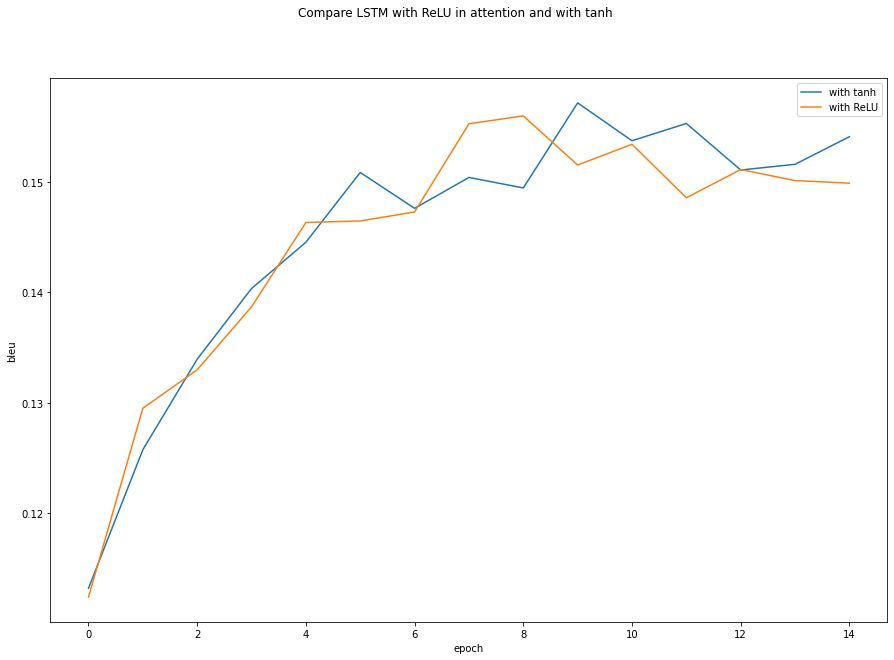

In [ ]:
fig, axs = plt.subplots(1, 1)
fig.suptitle("Compare LSTM with ReLU in attention and with tanh") 
axs.plot(bleu_tanh, label="with tanh")
axs.plot(bleu_lstm, label="with ReLU")
axs.legend()
axs.set(xlabel='epoch', ylabel='bleu')
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

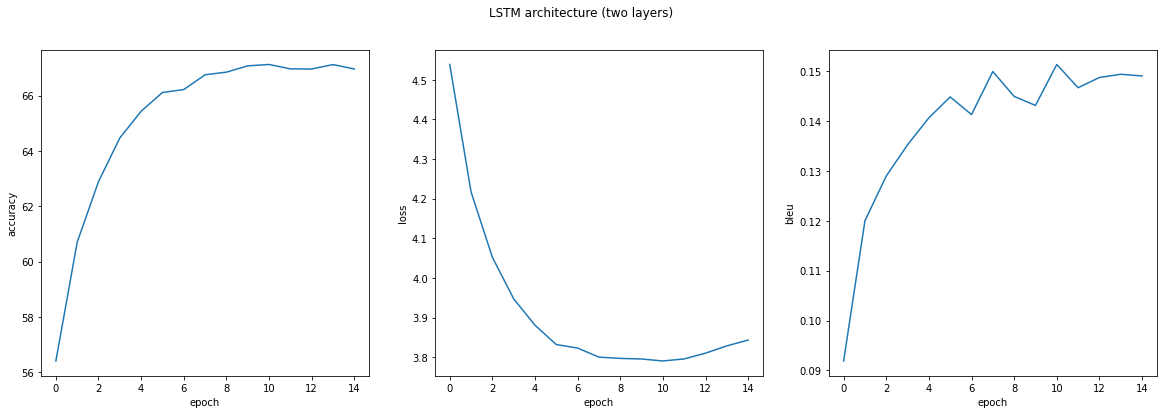

In [ ]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/LSTM2.txt")
plot_metrics(metrs, "LSTM architecture (two layers)")

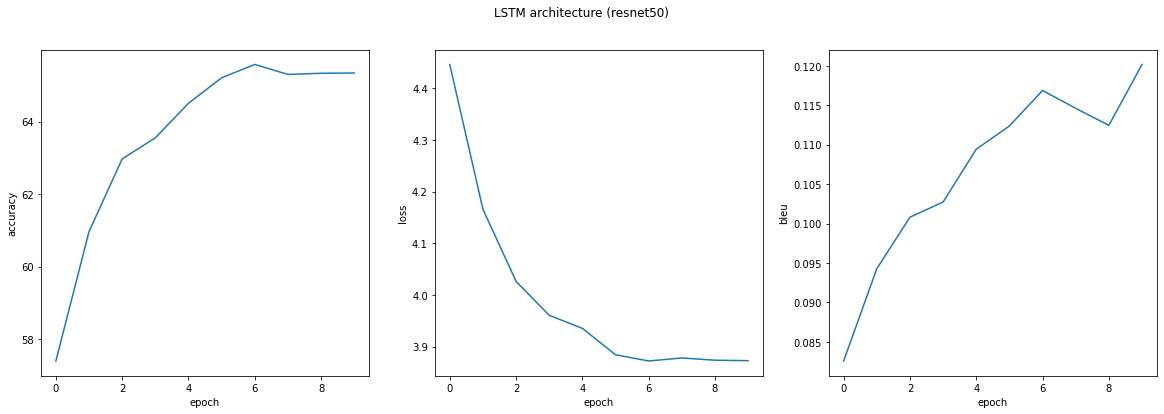

In [ ]:
metrs = calc_metrics("/content/drive/MyDrive/ImageCaptioning/LSTM_renet50.txt")
plot_metrics(metrs, "LSTM architecture (resnet50)")